# Customer Churn Prediction
Step-by-step implementation using machine learning algorithms

## Project Overview

This notebook demonstrates a step-by-step approach to predicting customer churn using machine learning algorithms. It covers data generation, exploratory analysis, preprocessing, model training, evaluation, feature importance, and deployment of a prediction function.

**Workflow Steps:**
1. Data generation and exploration
2. Data preprocessing and encoding
3. Model training (Logistic Regression, Random Forest, Gradient Boosting)
4. Model evaluation and comparison
5. Feature importance analysis
6. Churn prediction function for new customers

Use this notebook as a template for building and evaluating churn prediction models on customer datasets.

In [16]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Step 2: Create Sample Customer Dataset
np.random.seed(42)
n_customers = 5000

# Generate customer data
data = {
    'Age': np.random.randint(18, 70, n_customers),
    'Gender': np.random.choice(['Male', 'Female'], n_customers),
    'Tenure': np.random.randint(1, 72, n_customers),  # months
    'MonthlyCharges': np.random.uniform(20, 120, n_customers),
    'TotalCharges': np.random.uniform(100, 8000, n_customers),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_customers, p=[0.5, 0.3, 0.2]),
    'PaymentMethod': np.random.choice(['Credit card', 'Bank transfer', 'Electronic check', 'Mailed check'], n_customers),
    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], n_customers, p=[0.4, 0.4, 0.2]),
    'OnlineSecurity': np.random.choice(['Yes', 'No'], n_customers, p=[0.3, 0.7]),
    'TechSupport': np.random.choice(['Yes', 'No'], n_customers, p=[0.3, 0.7])
}

df = pd.DataFrame(data)

# Create churn probability based on logical rules (as a Series)
churn_prob = pd.Series(0.1, index=df.index)
churn_prob += (df['Contract'] == 'Month-to-month') * 0.3
churn_prob += (df['Tenure'] < 12) * 0.2
churn_prob += (df['MonthlyCharges'] > 80) * 0.15
churn_prob += (df['PaymentMethod'] == 'Electronic check') * 0.1
churn_prob -= (df['OnlineSecurity'] == 'Yes') * 0.1
churn_prob -= (df['TechSupport'] == 'Yes') * 0.1

# Ensure probabilities are valid
churn_prob = churn_prob.clip(0.0, 1.0)

# Sample churn labels
df['Churn'] = np.random.binomial(1, churn_prob)

print(f"Dataset shape: {df.shape}")
print(f"Churn rate: {df['Churn'].mean():.3f}")
print(df.head())

Dataset shape: (5000, 11)
Churn rate: 0.306
   Age  Gender  Tenure  MonthlyCharges  TotalCharges        Contract  \
0   56    Male      49       63.480153   5964.809025        Two year   
1   69  Female      70       40.076673   4035.152080        Two year   
2   46  Female      49       30.756139   7191.579934  Month-to-month   
3   32    Male       3       64.012770   7734.481522  Month-to-month   
4   60    Male       5       32.330581   2961.746971  Month-to-month   

      PaymentMethod InternetService OnlineSecurity TechSupport  Churn  
0      Mailed check     Fiber optic             No          No      0  
1      Mailed check             DSL             No         Yes      0  
2  Electronic check     Fiber optic            Yes          No      0  
3  Electronic check              No            Yes          No      0  
4     Bank transfer             DSL             No          No      0  


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              5000 non-null   int32  
 1   Gender           5000 non-null   object 
 2   Tenure           5000 non-null   int32  
 3   MonthlyCharges   5000 non-null   float64
 4   TotalCharges     5000 non-null   float64
 5   Contract         5000 non-null   object 
 6   PaymentMethod    5000 non-null   object 
 7   InternetService  5000 non-null   object 
 8   OnlineSecurity   5000 non-null   object 
 9   TechSupport      5000 non-null   object 
 10  Churn            5000 non-null   int32  
dtypes: float64(2), int32(3), object(6)
memory usage: 371.2+ KB
None

Churn Distribution:
Churn
0    3472
1    1528
Name: count, dtype: int64


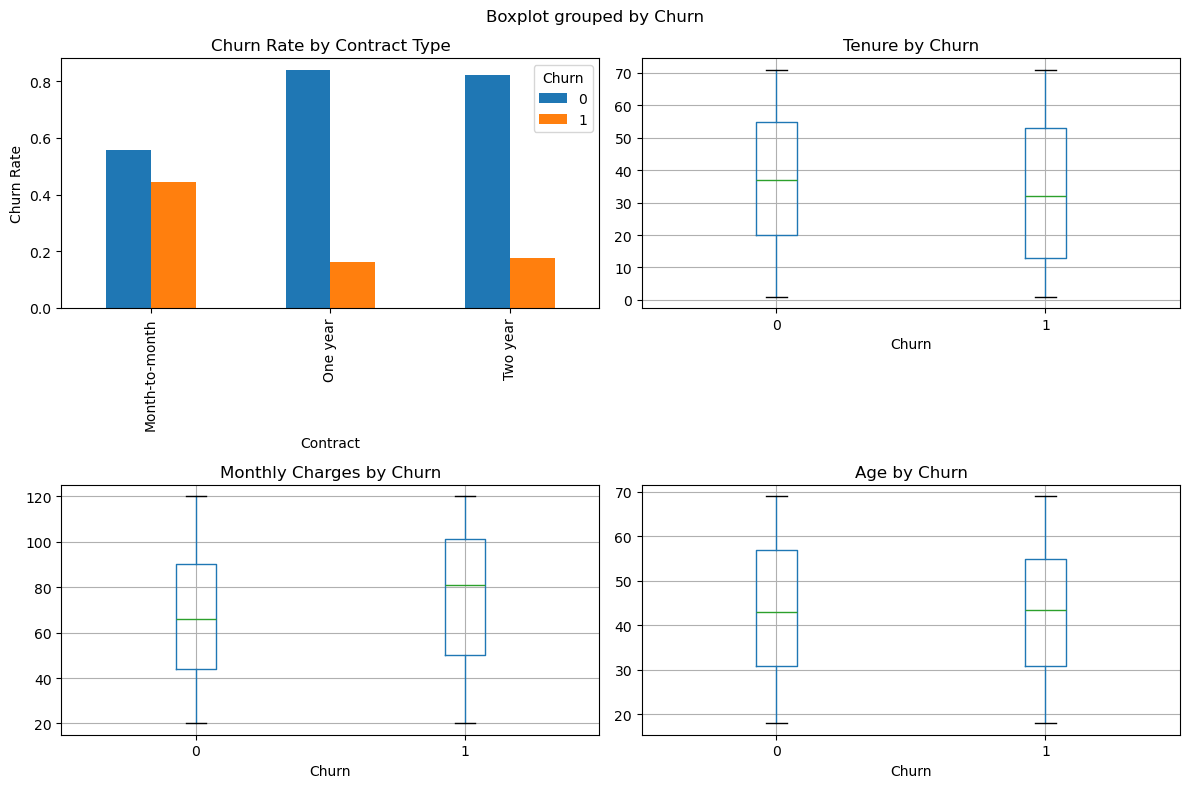

In [18]:
# Step 3: Exploratory Data Analysis
print("Dataset Info:")
print(df.info())
print("\nChurn Distribution:")
print(df['Churn'].value_counts())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Churn by Contract
pd.crosstab(df['Contract'], df['Churn'], normalize='index').plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Churn Rate by Contract Type')
axes[0,0].set_ylabel('Churn Rate')

# Churn by Tenure
df.boxplot(column='Tenure', by='Churn', ax=axes[0,1])
axes[0,1].set_title('Tenure by Churn')

# Churn by Monthly Charges
df.boxplot(column='MonthlyCharges', by='Churn', ax=axes[1,0])
axes[1,0].set_title('Monthly Charges by Churn')

# Age distribution
df.boxplot(column='Age', by='Churn', ax=axes[1,1])
axes[1,1].set_title('Age by Churn')

plt.tight_layout()
plt.show()

In [19]:
# Step 4: Data Preprocessing
# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['Gender', 'Contract', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'TechSupport']

df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])

# Separate features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Training churn rate: {y_train.mean():.3f}")

Training set shape: (4000, 10)
Test set shape: (1000, 10)
Training churn rate: 0.305


In [20]:
# Step 5: Logistic Regression Model
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, lr_pred))

=== LOGISTIC REGRESSION RESULTS ===
Accuracy: 0.6210

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       694
           1       0.43      0.71      0.53       306

    accuracy                           0.62      1000
   macro avg       0.62      0.65      0.61      1000
weighted avg       0.70      0.62      0.64      1000


Confusion Matrix:
[[403 291]
 [ 88 218]]


In [21]:
# Step 6: Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== RANDOM FOREST RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

=== RANDOM FOREST RESULTS ===
Accuracy: 0.6970

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       694
           1       0.51      0.27      0.36       306

    accuracy                           0.70      1000
   macro avg       0.62      0.58      0.58      1000
weighted avg       0.67      0.70      0.67      1000


Confusion Matrix:
[[613  81]
 [222  84]]


In [22]:
# Step 7: Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== GRADIENT BOOSTING RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, gb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, gb_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, gb_pred))

=== GRADIENT BOOSTING RESULTS ===
Accuracy: 0.7150

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       694
           1       0.56      0.33      0.42       306

    accuracy                           0.71      1000
   macro avg       0.65      0.61      0.61      1000
weighted avg       0.69      0.71      0.69      1000


Confusion Matrix:
[[613  81]
 [204 102]]


Random Forest Feature Importance:
           feature  importance
3   MonthlyCharges    0.213623
4     TotalCharges    0.180731
2           Tenure    0.174541
0              Age    0.148608
5         Contract    0.122354
6    PaymentMethod    0.052119
7  InternetService    0.041469
1           Gender    0.025267
8   OnlineSecurity    0.021450
9      TechSupport    0.019838

Gradient Boosting Feature Importance:
           feature  importance
5         Contract    0.373183
3   MonthlyCharges    0.234275
2           Tenure    0.147831
4     TotalCharges    0.108473
6    PaymentMethod    0.038526
0              Age    0.037060
9      TechSupport    0.030832
8   OnlineSecurity    0.023586
7  InternetService    0.004741
1           Gender    0.001493


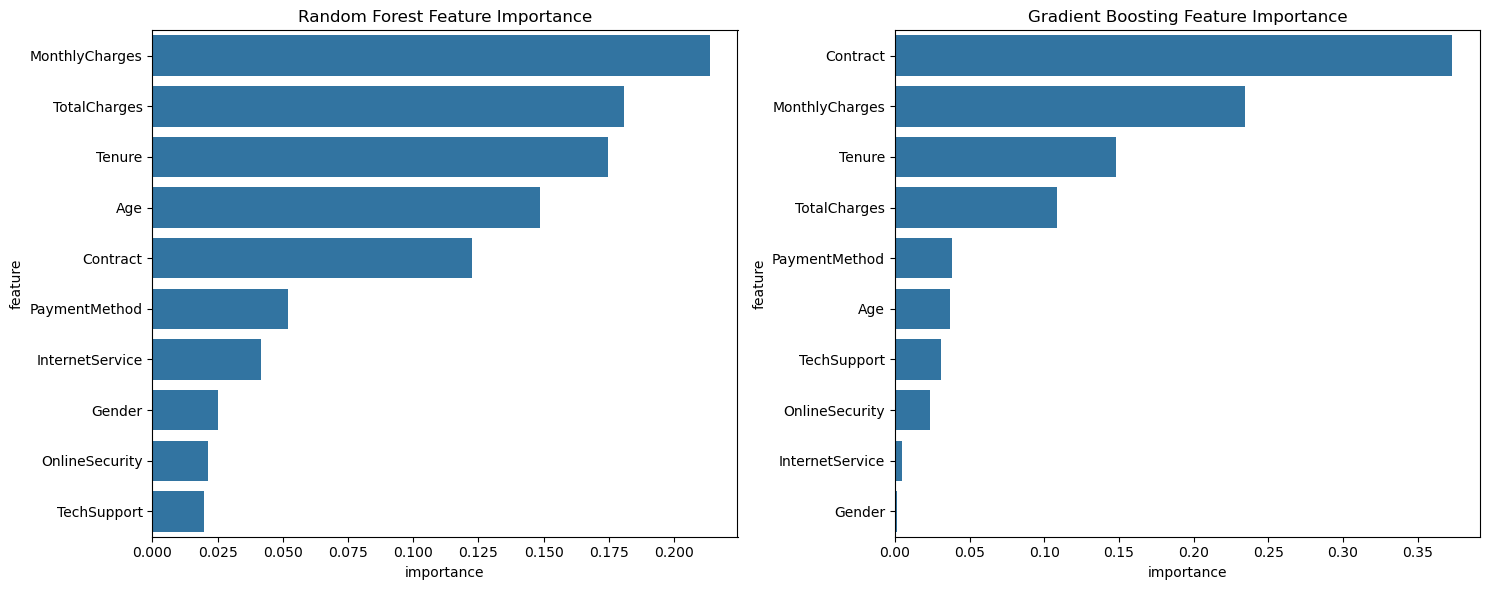

In [23]:
# Step 8: Feature Importance Analysis
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Gradient Boosting Feature Importance
gb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance)
print("\nGradient Boosting Feature Importance:")
print(gb_importance)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=rf_importance, y='feature', x='importance', ax=axes[0])
axes[0].set_title('Random Forest Feature Importance')

sns.barplot(data=gb_importance, y='feature', x='importance', ax=axes[1])
axes[1].set_title('Gradient Boosting Feature Importance')

plt.tight_layout()
plt.show()

Model Performance Comparison:
                 Model  Accuracy
0  Logistic Regression     0.621
1        Random Forest     0.697
2    Gradient Boosting     0.715


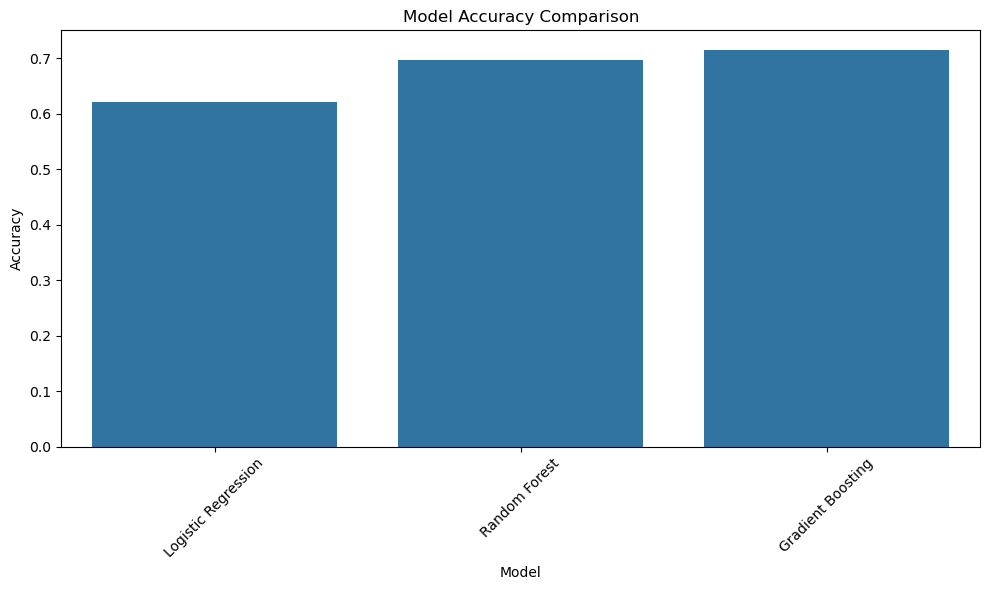


Best performing model: Gradient Boosting


In [24]:
# Step 9: Model Performance Comparison
models_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, gb_pred)
    ]
})

print("Model Performance Comparison:")
print(models_performance)

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=models_performance, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Best model
best_model_idx = models_performance['Accuracy'].idxmax()
best_model = models_performance.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model}")

In [25]:
# Step 10: Customer Churn Prediction Function
def predict_churn(age, gender, tenure, monthly_charges, total_charges, 
                  contract, payment_method, internet_service, 
                  online_security, tech_support, model='rf'):
    """Predict customer churn probability"""
    
    # Encode categorical inputs
    gender_encoded = 1 if gender.lower() == 'male' else 0
    contract_map = {'month-to-month': 0, 'one year': 1, 'two year': 2}
    contract_encoded = contract_map.get(contract.lower(), 0)
    payment_map = {'bank transfer': 0, 'credit card': 1, 'electronic check': 2, 'mailed check': 3}
    payment_encoded = payment_map.get(payment_method.lower(), 0)
    internet_map = {'dsl': 0, 'fiber optic': 1, 'no': 2}
    internet_encoded = internet_map.get(internet_service.lower(), 0)
    security_encoded = 1 if online_security.lower() == 'yes' else 0
    support_encoded = 1 if tech_support.lower() == 'yes' else 0
    
    # Create input array
    input_data = np.array([[age, gender_encoded, tenure, monthly_charges, total_charges,
                           contract_encoded, payment_encoded, internet_encoded,
                           security_encoded, support_encoded]])
    
    # Choose model and predict
    if model == 'lr':
        # Scale numerical features for logistic regression
        input_scaled = input_data.copy()
        input_scaled[:, [0, 2, 3, 4]] = scaler.transform(input_data[:, [0, 2, 3, 4]])
        prediction = lr_model.predict(input_scaled)[0]
        probability = lr_model.predict_proba(input_scaled)[0][1]
    elif model == 'gb':
        prediction = gb_model.predict(input_data)[0]
        probability = gb_model.predict_proba(input_data)[0][1]
    else:  # Random Forest (default)
        prediction = rf_model.predict(input_data)[0]
        probability = rf_model.predict_proba(input_data)[0][1]
    
    return prediction, probability

# Test the function
print("Testing Churn Prediction Function:")
print("\nLow Risk Customer:")
pred, prob = predict_churn(45, 'Female', 36, 45.0, 1500.0, 'Two year', 
                          'Credit card', 'DSL', 'Yes', 'Yes')
print(f"Prediction: {'CHURN' if pred == 1 else 'STAY'}, Probability: {prob:.4f}")

print("\nHigh Risk Customer:")
pred, prob = predict_churn(25, 'Male', 3, 95.0, 300.0, 'Month-to-month', 
                          'Electronic check', 'Fiber optic', 'No', 'No')
print(f"Prediction: {'CHURN' if pred == 1 else 'STAY'}, Probability: {prob:.4f}")

Testing Churn Prediction Function:

Low Risk Customer:
Prediction: STAY, Probability: 0.0100

High Risk Customer:
Prediction: CHURN, Probability: 0.6000


c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
